<a href="https://colab.research.google.com/github/AbouCamara/IA-FORCE-N/blob/main/Syst%C3%A8me_de_Classification_d'images_de_cultures_agricoles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proposition de Monsieur CAMARA

In [1]:
import kagglehub
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import defaultdict
from tqdm import tqdm
from google.colab import drive
from PIL import Image
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
# Monter Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Définir le chemin du fichier zip et du dossier d'extraction
zip_path = '/content/drive/MyDrive/Data/extracted_files/archive.zip'  # Mettre à jour si nécessaire
extract_folder = '/content/drive/MyDrive/Data/Agricultural-corps/extracted/'  # Dossier où extraire

# Vérifier si le fichier zip existe et est un fichier zip valide
if os.path.exists(zip_path) and zipfile.is_zipfile(zip_path):
    # Créer le dossier d'extraction si nécessaire
    os.makedirs(extract_folder, exist_ok=True)

    # Dézipper le fichier
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    print(f"Fichiers extraits dans {extract_folder}")
else:
    print(f"Le fichier à {zip_path} n'existe pas ou n'est pas un fichier zip valide. Vérifiez le chemin et l'intégrité du fichier.")

Le fichier à /content/drive/MyDrive/Data/extracted_files/archive.zip n'existe pas ou n'est pas un fichier zip valide. Vérifiez le chemin et l'intégrité du fichier.


In [4]:
# Chemin d'accès aux images
# Chemin vers votre dossier dans Google Drive
drive_path = '/content/drive/MyDrive/Data/extracted_files/Agricultural-crops'
## drive_path ='/content/drive/MyDrive/Colab Notebooks/Agricultural-crops'
# Vérifier le contenu du dossier
!ls "{drive_path}"

 almond         cotton		    image20.jpeg   model.keras		  sunflower
 augmented      Cucumber	    image21.jpeg   mustard-oil		  tea
 banana         flipped		    image22.jpeg   Olive-tree		  Tobacco-plant
 cardamom      'Fox_nut(Makhana)'   image24.jpeg   papaya		  tomato
 Cherry         gram		    jowar	  'Pearl_millet(bajra)'  'vigna-radiati(Mung)'
 chilli         image15.jpeg	    jute	   pineapple		  wheat
 clove	        image16.jpeg	    Lemon	   rice
 coconut        image17.jpeg	    maize	   soyabean
 Coffee-plant   image18.jpeg	    model.h5	   sugarcane


In [5]:
def load_images_from_drive(folder_path, img_size=(128, 128), max_images=None):
    """
    Loads images from Google Drive, ensuring image data is loaded correctly.

    Args:
        folder_path (str): Relative path within Google Drive.
        img_size (tuple): Resizing dimensions.
        max_images (int): Maximum number of images to load (None = all).

    Returns:
        tuple: (images, labels, class_names)
    """
    full_path = os.path.join(drive_path, folder_path)
    class_names = sorted([d for d in os.listdir(full_path) if os.path.isdir(os.path.join(full_path, d))])

    images = []
    labels = []

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(full_path, class_name)
        files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if max_images:
            files = files[:max_images]

        print(f"Chargement {len(files)} images de la classe {class_name}...")

        for file in tqdm(files):
            try:
                img_path = os.path.join(class_dir, file)
                # Load actual image data using cv2.imread
                img = cv2.imread(img_path)

                if img is None:
                    continue

                # Conversion BGR vers RGB + redimensionnement
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                img = img.astype(np.float32) / 255.0  # Normalisation

                images.append(img)
                labels.append(label)

            except Exception as e:
                print(f"Erreur avec {file}: {str(e)}")

    return np.array(images), np.array(labels), class_names # Convert to NumPy arrays

# **Augmentation de données**

In [6]:
# Dossier contenant les images à augmenter
input_folder = '/content/drive/MyDrive/Data/extracted_files/Agricultural-crops/'

# Dossier de sortie pour les images augmentées
output_folder = '/content/drive/MyDrive/Data/extracted_files/Agricultural-crops/augmented/'

# Crée le dossier de sortie s'il n'existe pas
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Parcours les fichiers dans le dossier d'entrée
for file_name in os.listdir(input_folder):
    file_path = os.path.join(input_folder, file_name)

    # Vérifie si c'est un fichier image
    if os.path.isfile(file_path) and file_name.endswith(('jpg', 'jpeg', 'png')):
        try:
            # Ouvre l'image
            image = Image.open(file_path)

            # Applique les augmentations : retournement horizontal et vertical
            if random.choice([True, False]):  # 50% de chance pour chaque transformation
                image = image.transpose(Image.FLIP_LEFT_RIGHT)  # Retournement horizontal
            if random.choice([True, False]):
                image = image.transpose(Image.FLIP_TOP_BOTTOM)  # Retournement vertical

            # Sauvegarde l'image augmentée
            augmented_image_path = os.path.join(output_folder, file_name)
            image.save(augmented_image_path)

            print(f"Image augmentée sauvegardée : {augmented_image_path}")

        except Exception as e:
            print(f"Erreur lors de l'ouverture ou de l'augmentation de l'image {file_name}: {e}")


Image augmentée sauvegardée : /content/drive/MyDrive/Data/extracted_files/Agricultural-crops/augmented/image17.jpeg
Image augmentée sauvegardée : /content/drive/MyDrive/Data/extracted_files/Agricultural-crops/augmented/image18.jpeg
Image augmentée sauvegardée : /content/drive/MyDrive/Data/extracted_files/Agricultural-crops/augmented/image20.jpeg
Image augmentée sauvegardée : /content/drive/MyDrive/Data/extracted_files/Agricultural-crops/augmented/image24.jpeg
Image augmentée sauvegardée : /content/drive/MyDrive/Data/extracted_files/Agricultural-crops/augmented/image21.jpeg
Image augmentée sauvegardée : /content/drive/MyDrive/Data/extracted_files/Agricultural-crops/augmented/image16.jpeg
Image augmentée sauvegardée : /content/drive/MyDrive/Data/extracted_files/Agricultural-crops/augmented/image22.jpeg
Image augmentée sauvegardée : /content/drive/MyDrive/Data/extracted_files/Agricultural-crops/augmented/image15.jpeg


Chargement 32 images de la classe Cherry...


100%|██████████| 32/32 [00:09<00:00,  3.40it/s]


Chargement 29 images de la classe Coffee-plant...


100%|██████████| 29/29 [00:08<00:00,  3.31it/s]


Chargement 31 images de la classe Cucumber...


100%|██████████| 31/31 [00:10<00:00,  2.94it/s]


Chargement 23 images de la classe Fox_nut(Makhana)...


100%|██████████| 23/23 [00:06<00:00,  3.33it/s]


Chargement 28 images de la classe Lemon...


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Chargement 30 images de la classe Olive-tree...


100%|██████████| 30/30 [00:09<00:00,  3.05it/s]


Chargement 39 images de la classe Pearl_millet(bajra)...


100%|██████████| 39/39 [00:11<00:00,  3.26it/s]


Chargement 33 images de la classe Tobacco-plant...


100%|██████████| 33/33 [00:10<00:00,  3.26it/s]


Chargement 21 images de la classe almond...


100%|██████████| 21/21 [00:07<00:00,  2.83it/s]


Chargement 8 images de la classe augmented...


100%|██████████| 8/8 [00:00<00:00, 139.34it/s]


Chargement 31 images de la classe banana...


100%|██████████| 31/31 [00:11<00:00,  2.67it/s]


Chargement 22 images de la classe cardamom...


100%|██████████| 22/22 [00:06<00:00,  3.21it/s]


Chargement 23 images de la classe chilli...


100%|██████████| 23/23 [00:07<00:00,  3.04it/s]


Chargement 30 images de la classe clove...


100%|██████████| 30/30 [00:08<00:00,  3.37it/s]


Chargement 25 images de la classe coconut...


100%|██████████| 25/25 [00:07<00:00,  3.22it/s]


Chargement 32 images de la classe cotton...


100%|██████████| 32/32 [00:09<00:00,  3.41it/s]


Chargement 0 images de la classe flipped...


0it [00:00, ?it/s]


Chargement 25 images de la classe gram...


100%|██████████| 25/25 [00:07<00:00,  3.13it/s]


Chargement 30 images de la classe jowar...


100%|██████████| 30/30 [00:09<00:00,  3.25it/s]


Chargement 23 images de la classe jute...


100%|██████████| 23/23 [00:07<00:00,  2.92it/s]


Chargement 31 images de la classe maize...


100%|██████████| 31/31 [00:09<00:00,  3.11it/s]


Chargement 28 images de la classe mustard-oil...


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Chargement 23 images de la classe papaya...


100%|██████████| 23/23 [00:08<00:00,  2.79it/s]


Chargement 25 images de la classe pineapple...


100%|██████████| 25/25 [00:07<00:00,  3.18it/s]


Chargement 29 images de la classe rice...


100%|██████████| 29/29 [00:09<00:00,  3.20it/s]


Chargement 30 images de la classe soyabean...


100%|██████████| 30/30 [00:08<00:00,  3.42it/s]


Chargement 25 images de la classe sugarcane...


100%|██████████| 25/25 [00:07<00:00,  3.24it/s]


Chargement 24 images de la classe sunflower...


100%|██████████| 24/24 [00:07<00:00,  3.18it/s]


Chargement 23 images de la classe tea...


100%|██████████| 23/23 [00:07<00:00,  3.14it/s]


Chargement 26 images de la classe tomato...


100%|██████████| 26/26 [00:09<00:00,  2.87it/s]


Chargement 27 images de la classe vigna-radiati(Mung)...


100%|██████████| 27/27 [00:08<00:00,  3.13it/s]


Chargement 31 images de la classe wheat...


100%|██████████| 31/31 [00:09<00:00,  3.32it/s]



Dimensions des données : (837, 128, 128, 3)
Exemple de label : 0 (Cherry)


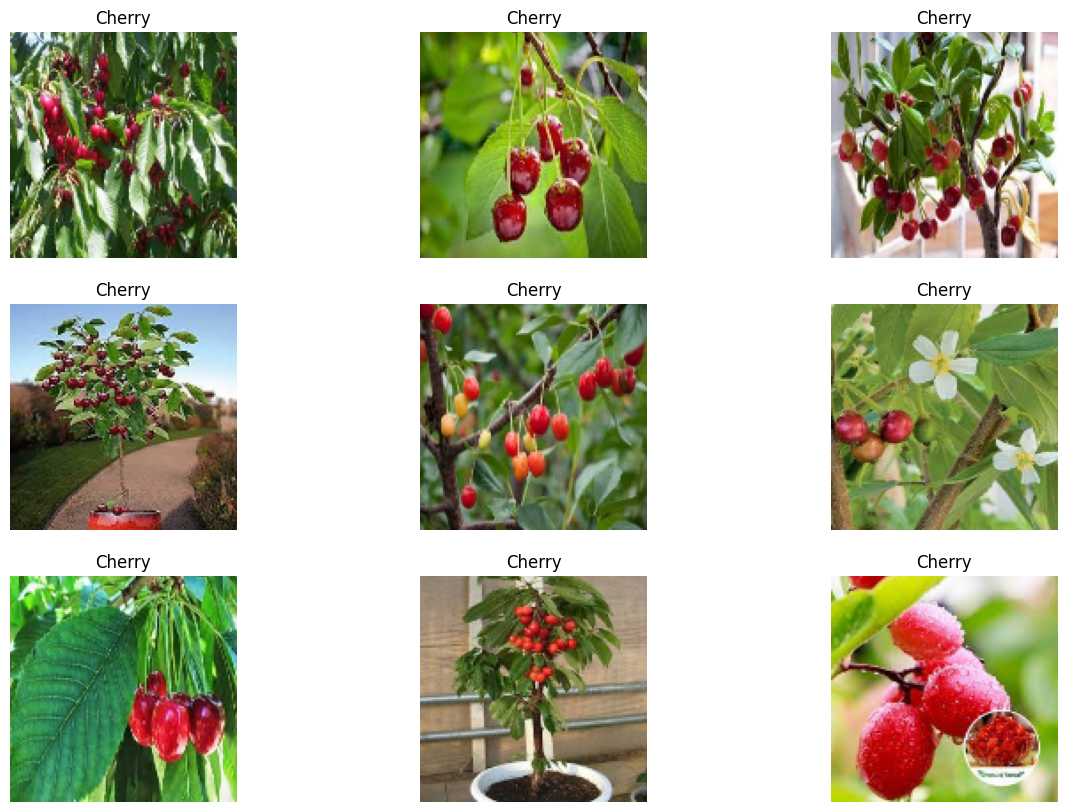

In [7]:
# Utilisation

# Exemple de chemin (à adapter)
dataset_folder = '/content/drive/MyDrive/Data/extracted_files/Agricultural-crops'  # Doit contenir des sous-dossiers par classe
## dataset_folder ='/content/drive/MyDrive/Colab Notebooks/Agricultural-crops'
# Chargement
images, labels, classes = load_images_from_drive(
    folder_path=dataset_folder,
    img_size=(128, 128),
    max_images=1000  # Limiter à 1000 images par classe
)

# Vérification
print(f"\nDimensions des données : {images.shape}")
print(f"Exemple de label : {labels[0]} ({classes[labels[0]]})")

# Visualisation
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()

# Analyse exploratoire des données

Nombre total de classes: 32


<ipython-input-27-bc40f83ec3c1>:38: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


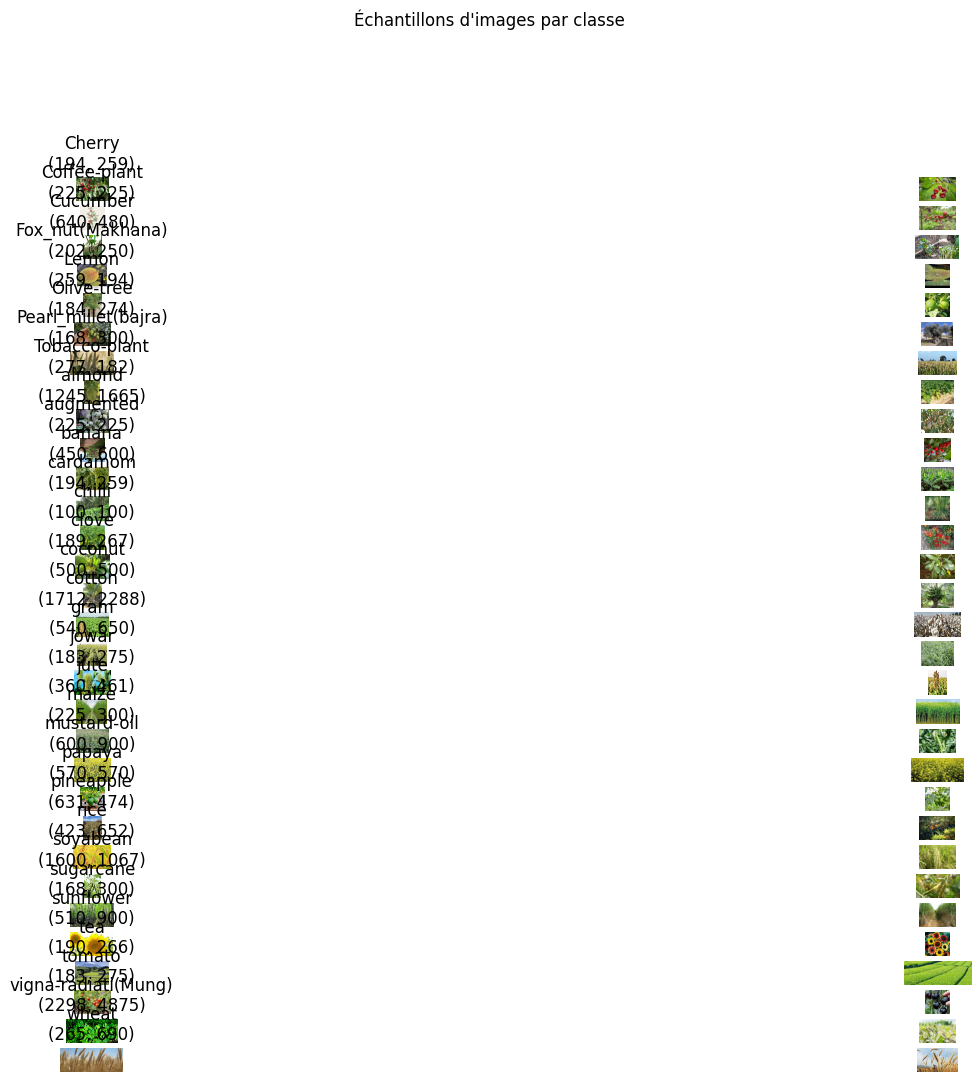

<ipython-input-27-bc40f83ec3c1>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.values()), y=list(class_counts.keys()), palette="viridis")


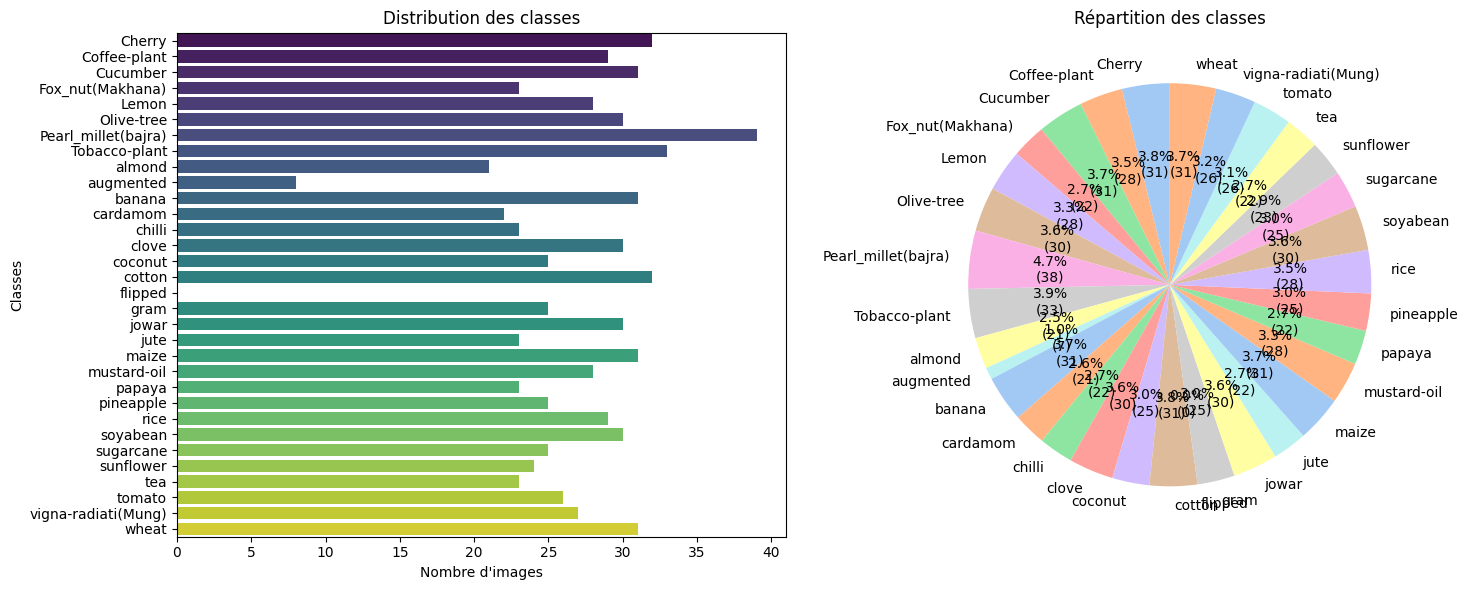


Statistiques détaillées:
Nombre total d'images: 837
Nombre moyen d'images par classe: 26.2
Écart-type: 7.0
Classe la plus fréquente: Pearl_millet(bajra) (39 images)
Classe la moins fréquente: flipped (0 images)

⚠️ Alerte: Déséquilibre important détecté !
Ratio min/max: 0.00
Solutions possibles:
- Data Augmentation pour les classes minoritaires
- Rééchantillonnage (oversampling/undersampling)
- Utilisation de class weights pendant l'entraînement


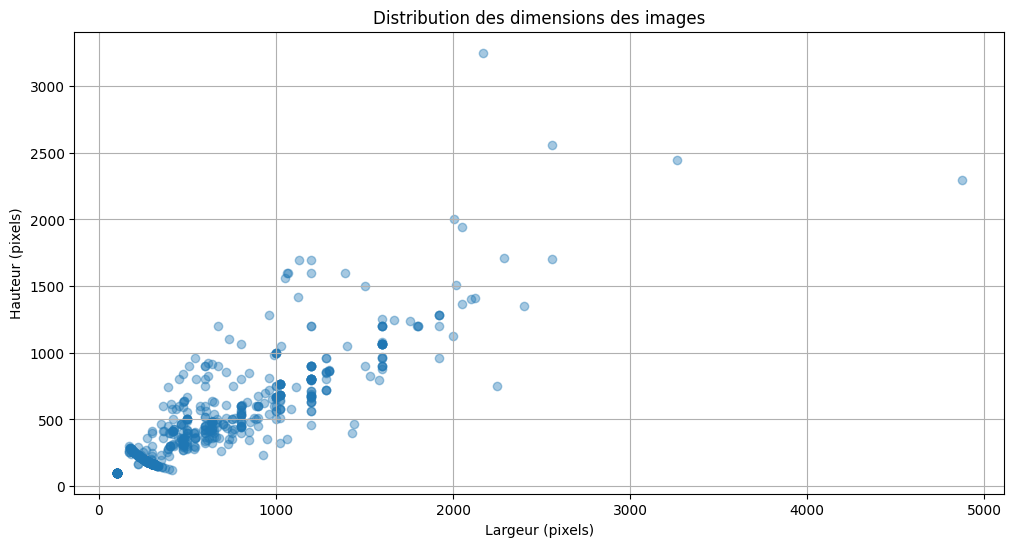

In [27]:
# Configuration
# Chemin vers vos données
DATASET_PATH = '/content/drive/MyDrive/Data/extracted_files/Agricultural-crops'

# Nombre d'échantillons à visualiser par classe
SAMPLE_PER_CLASS = 2

# 1. Exploration initiale du dataset
class_counts = defaultdict(int)
class_names = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])

print(f"Nombre total de classes: {len(class_names)}")

# 2. Visualisation d'échantillons d'images
plt.figure(figsize=(20, 12))
plot_index = 1

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(DATASET_PATH, class_name)
    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    class_counts[class_name] = len(images)

    # Affichage d'échantillons d'images
    for img_idx in range(SAMPLE_PER_CLASS):
        if img_idx >= len(images):
            break

        img_path = os.path.join(class_dir, images[img_idx])
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        plt.subplot(len(class_names), SAMPLE_PER_CLASS, plot_index)
        plt.imshow(img)
        plt.title(f"{class_name}\n{img.shape[:2]}" if img_idx == 0 else "")
        plt.axis('off')
        plot_index += 1

plt.suptitle("Échantillons d'images par classe", y=1.02)
plt.tight_layout()
plt.show()

# 3. Analyse de la distribution des classes
plt.figure(figsize=(15, 6))

# Diagramme en barres
plt.subplot(1, 2, 1)
sns.barplot(x=list(class_counts.values()), y=list(class_counts.keys()), palette="viridis")
plt.title("Distribution des classes")
plt.xlabel("Nombre d'images")
plt.ylabel("Classes")

# Diagramme circulaire
plt.subplot(1, 2, 2)
plt.pie(class_counts.values(),
        labels=class_counts.keys(),
        autopct=lambda p: f'{p:.1f}%\n({int(p*sum(class_counts.values())/100)})',
        startangle=90,
        colors=sns.color_palette("pastel"))
plt.title("Répartition des classes")
plt.tight_layout()
plt.show()

# 4. Statistiques détaillées
total_images = sum(class_counts.values())
print("\nStatistiques détaillées:")
print(f"Nombre total d'images: {total_images}")
print(f"Nombre moyen d'images par classe: {np.mean(list(class_counts.values())):.1f}")
print(f"Écart-type: {np.std(list(class_counts.values())):.1f}")
print(f"Classe la plus fréquente: {max(class_counts, key=class_counts.get)} ({max(class_counts.values())} images)")
print(f"Classe la moins fréquente: {min(class_counts, key=class_counts.get)} ({min(class_counts.values())} images)")

# 5. Détection des déséquilibres

# Ratio acceptable entre plus petite et plus grande classe
balance_threshold = 0.3
max_count = max(class_counts.values())
min_count = min(class_counts.values())

if min_count/max_count < balance_threshold:
    print("\n⚠️ Alerte: Déséquilibre important détecté !")
    print(f"Ratio min/max: {min_count/max_count:.2f}")
    print("Solutions possibles:")
    print("- Data Augmentation pour les classes minoritaires")
    print("- Rééchantillonnage (oversampling/undersampling)")
    print("- Utilisation de class weights pendant l'entraînement")
else:
    print("\n✅ Distribution relativement équilibrée")

# 6. Visualisation avancée des dimensions d'images
sizes = []
for class_name in class_names:
    class_dir = os.path.join(DATASET_PATH, class_name)
    for img_file in os.listdir(class_dir)[:100]:  # Échantillonner pour gagner du temps
        img = cv2.imread(os.path.join(class_dir, img_file))
        if img is not None:
            sizes.append(img.shape[:2])

sizes = np.array(sizes)
plt.figure(figsize=(12, 6))
plt.scatter(sizes[:, 1], sizes[:, 0], alpha=0.4)  # width vs height
plt.title("Distribution des dimensions des images")
plt.xlabel("Largeur (pixels)")
plt.ylabel("Hauteur (pixels)")
plt.grid(True)
plt.show()

In [10]:
# Définition du modèle CNN : Réseau neuronal convolutionnel
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           4,128 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,308,768 (12.62 MB)

 Trainable params: 3,308,768 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Division des données
total_size = len(images)
train_size = int(0.8 * total_size)
X_train, X_test = images[:train_size], images[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

In [23]:
# Code précédent :
# images, labels, classes = load_images_from_drive(dataset_folder)

# Code modifié pour charger les données d'image réelles :
images, labels, classes = load_images_from_drive(dataset_folder, img_size=(128, 128))

# Mettre à jour X_train, X_test en conséquence (comme avant)
total_size = len(images)
train_size = int(0.8 * total_size)
X_train, X_test = images[:train_size], images[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

Chargement 32 images de la classe Cherry...


100%|██████████| 32/32 [00:00<00:00, 143.20it/s]


Chargement 29 images de la classe Coffee-plant...


100%|██████████| 29/29 [00:00<00:00, 129.79it/s]


Chargement 31 images de la classe Cucumber...


100%|██████████| 31/31 [00:00<00:00, 58.02it/s]


Chargement 23 images de la classe Fox_nut(Makhana)...


100%|██████████| 23/23 [00:00<00:00, 157.51it/s]


Chargement 28 images de la classe Lemon...


100%|██████████| 28/28 [00:00<00:00, 146.12it/s]


Chargement 30 images de la classe Olive-tree...


100%|██████████| 30/30 [00:00<00:00, 55.20it/s]


Chargement 39 images de la classe Pearl_millet(bajra)...


100%|██████████| 39/39 [00:00<00:00, 74.00it/s]


Chargement 33 images de la classe Tobacco-plant...


100%|██████████| 33/33 [00:00<00:00, 145.69it/s]


Chargement 21 images de la classe almond...


100%|██████████| 21/21 [00:00<00:00, 60.99it/s]


Chargement 8 images de la classe augmented...


100%|██████████| 8/8 [00:00<00:00, 147.93it/s]


Chargement 31 images de la classe banana...


100%|██████████| 31/31 [00:00<00:00, 43.17it/s]


Chargement 22 images de la classe cardamom...


100%|██████████| 22/22 [00:00<00:00, 120.34it/s]


Chargement 23 images de la classe chilli...


100%|██████████| 23/23 [00:00<00:00, 132.10it/s]


Chargement 30 images de la classe clove...


100%|██████████| 30/30 [00:00<00:00, 143.62it/s]


Chargement 25 images de la classe coconut...


100%|██████████| 25/25 [00:00<00:00, 42.28it/s]


Chargement 32 images de la classe cotton...


100%|██████████| 32/32 [00:00<00:00, 47.18it/s]


Chargement 0 images de la classe flipped...


0it [00:00, ?it/s]


Chargement 25 images de la classe gram...


100%|██████████| 25/25 [00:00<00:00, 44.35it/s]


Chargement 30 images de la classe jowar...


100%|██████████| 30/30 [00:00<00:00, 47.74it/s]


Chargement 23 images de la classe jute...


100%|██████████| 23/23 [00:00<00:00, 61.57it/s]


Chargement 31 images de la classe maize...


100%|██████████| 31/31 [00:00<00:00, 71.70it/s]


Chargement 28 images de la classe mustard-oil...


100%|██████████| 28/28 [00:00<00:00, 85.86it/s]


Chargement 23 images de la classe papaya...


100%|██████████| 23/23 [00:00<00:00, 59.79it/s]


Chargement 25 images de la classe pineapple...


100%|██████████| 25/25 [00:00<00:00, 105.01it/s]


Chargement 29 images de la classe rice...


100%|██████████| 29/29 [00:00<00:00, 66.99it/s]


Chargement 30 images de la classe soyabean...


100%|██████████| 30/30 [00:00<00:00, 75.46it/s]


Chargement 25 images de la classe sugarcane...


100%|██████████| 25/25 [00:00<00:00, 61.72it/s]


Chargement 24 images de la classe sunflower...


100%|██████████| 24/24 [00:00<00:00, 62.46it/s]


Chargement 23 images de la classe tea...


100%|██████████| 23/23 [00:00<00:00, 154.61it/s]


Chargement 26 images de la classe tomato...


100%|██████████| 26/26 [00:00<00:00, 89.37it/s]


Chargement 27 images de la classe vigna-radiati(Mung)...


100%|██████████| 27/27 [00:00<00:00, 77.45it/s]


Chargement 31 images de la classe wheat...


100%|██████████| 31/31 [00:00<00:00, 69.36it/s]


Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.0508 - loss: 3.4858 - val_accuracy: 0.0000e+00 - val_loss: 5.3601
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.1333 - loss: 3.0427 - val_accuracy: 0.0000e+00 - val_loss: 7.7861
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.1904 - loss: 2.7946 - val_accuracy: 0.0000e+00 - val_loss: 9.1532
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.2604 - loss: 2.5171 - val_accuracy: 0.0000e+00 - val_loss: 14.1131
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3779 - loss: 2.1586 - val_accuracy: 0.0000e+00 - val_loss: 14.6275
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4979 - loss: 1.6754 - val_accuracy: 0.0060 - val_loss: 20.0344
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6797 - loss: 1.2194 - val_accuracy: 0.0179 - val_loss: 23.1593
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7604 - loss: 0.8522 - val_accu

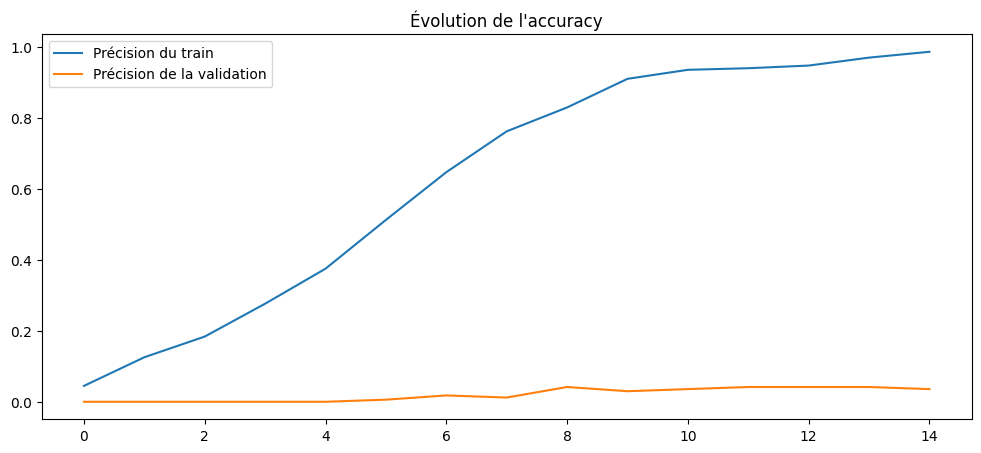

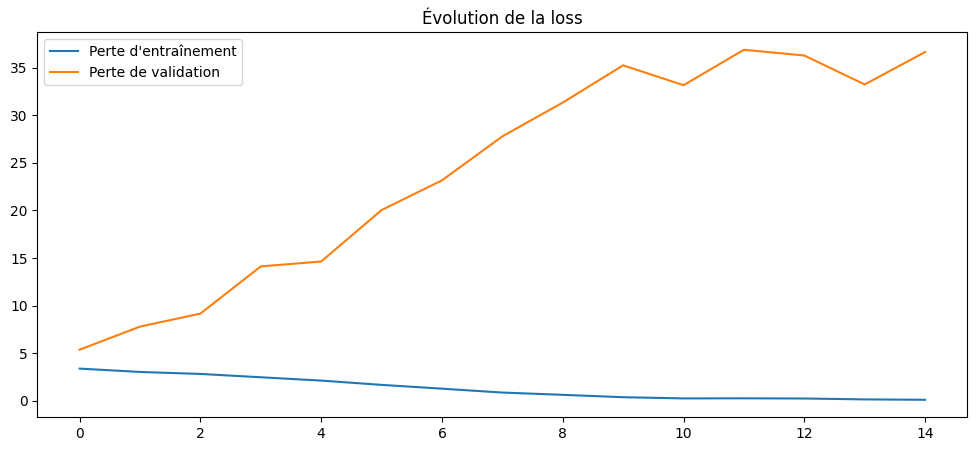

In [25]:
# Entraînement du modèle et sauvegarde de l'historique dans la variable 'history'
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

# Affichage des courbes d'apprentissage
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Précision du train')
plt.plot(history.history['val_accuracy'], label='Précision de la validation')
plt.legend()
plt.title("Évolution de l'accuracy")
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.legend()
plt.title("Évolution de la loss")
plt.show()

In [26]:
# Sauvegarde du modèle au format Keras natif
model.save('/content/drive/MyDrive/Data/extracted_files/Agricultural-crops/model.keras')

model.save('/content/drive/MyDrive/Data/extracted_files/Agricultural-crops/model.h5')

Proposition de Mamoudou SOW

In [ ]:
import kagglehub
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import defaultdict
from tqdm import tqdm
from google.colab import drive

In [ ]:
 """
# Décompression des fichiers
zip_path = '/content/drive/MyDrive/Systeme de classification d\'image/archive.zip'
extract_folder = '/content/drive/MyDrive/Data/extracted_files'
os.makedirs(extract_folder, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)
print(f"Fichiers extraits dans : {extract_folder}")
"""

'\n# Décompression des fichiers\nzip_path = \'/content/drive/MyDrive/Systeme de classification d\'image/archive.zip\'\nextract_folder = \'/content/drive/MyDrive/Data/extracted_files\'\nos.makedirs(extract_folder, exist_ok=True)\nwith zipfile.ZipFile(zip_path, \'r\') as zip_ref:\n   zip_ref.extractall(extract_folder)\nprint(f"Fichiers extraits dans : {extract_folder}")\n'

In [ ]:

# Chemin des images
dataset_folder = os.path.join(extract_folder, "Agricultural-crops")


In [ ]:
# Chargement des images avec détection d'erreurs
def load_images_from_drive(folder_path, img_size=(128, 128), max_images=1000):
    class_names = sorted([d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))])
    images, labels = [], []

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(folder_path, class_name)
        files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:max_images]
        print(f"Chargement de {len(files)} images pour {class_name}...")

        for file in tqdm(files):
            try:
                img_path = os.path.join(class_dir, file)
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Image corrompue ignorée: {file}")
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                img = img.astype(np.float32) / 255.0
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Erreur avec {file}: {str(e)}")

    return np.array(images), np.array(labels), class_names

Chargement de 32 images pour Cherry...


100%|██████████| 32/32 [00:00<00:00, 147.00it/s]


Chargement de 29 images pour Coffee-plant...


100%|██████████| 29/29 [00:00<00:00, 137.37it/s]


Chargement de 31 images pour Cucumber...


100%|██████████| 31/31 [00:00<00:00, 59.75it/s]


Chargement de 23 images pour Fox_nut(Makhana)...


100%|██████████| 23/23 [00:00<00:00, 146.94it/s]


Chargement de 28 images pour Lemon...


100%|██████████| 28/28 [00:00<00:00, 156.24it/s]


Chargement de 30 images pour Olive-tree...


100%|██████████| 30/30 [00:00<00:00, 75.60it/s]


Chargement de 39 images pour Pearl_millet(bajra)...


100%|██████████| 39/39 [00:00<00:00, 85.44it/s]


Chargement de 33 images pour Tobacco-plant...


100%|██████████| 33/33 [00:00<00:00, 142.10it/s]


Chargement de 21 images pour almond...


100%|██████████| 21/21 [00:00<00:00, 63.35it/s]


Chargement de 31 images pour banana...


100%|██████████| 31/31 [00:00<00:00, 48.22it/s]


Chargement de 22 images pour cardamom...


100%|██████████| 22/22 [00:00<00:00, 130.74it/s]


Chargement de 23 images pour chilli...


100%|██████████| 23/23 [00:00<00:00, 158.68it/s]


Chargement de 30 images pour clove...


100%|██████████| 30/30 [00:00<00:00, 143.20it/s]


Chargement de 25 images pour coconut...


100%|██████████| 25/25 [00:00<00:00, 53.91it/s]


Chargement de 32 images pour cotton...


100%|██████████| 32/32 [00:00<00:00, 58.43it/s]


Chargement de 0 images pour flipped...


0it [00:00, ?it/s]


Chargement de 25 images pour gram...


100%|██████████| 25/25 [00:00<00:00, 49.76it/s]


Chargement de 30 images pour jowar...


100%|██████████| 30/30 [00:00<00:00, 51.01it/s]


Chargement de 23 images pour jute...


100%|██████████| 23/23 [00:00<00:00, 64.17it/s]


Chargement de 31 images pour maize...


100%|██████████| 31/31 [00:00<00:00, 66.08it/s]


Chargement de 28 images pour mustard-oil...


100%|██████████| 28/28 [00:00<00:00, 75.36it/s]


Chargement de 23 images pour papaya...


100%|██████████| 23/23 [00:00<00:00, 49.77it/s]


Chargement de 25 images pour pineapple...


100%|██████████| 25/25 [00:00<00:00, 98.86it/s]


Chargement de 29 images pour rice...


100%|██████████| 29/29 [00:00<00:00, 55.10it/s]


Chargement de 30 images pour soyabean...


100%|██████████| 30/30 [00:00<00:00, 67.28it/s]


Chargement de 25 images pour sugarcane...


100%|██████████| 25/25 [00:00<00:00, 54.59it/s]


Chargement de 24 images pour sunflower...


100%|██████████| 24/24 [00:01<00:00, 21.08it/s]


Chargement de 23 images pour tea...


100%|██████████| 23/23 [00:00<00:00, 141.51it/s]


Chargement de 26 images pour tomato...


100%|██████████| 26/26 [00:00<00:00, 89.08it/s]


Chargement de 27 images pour vigna-radiati(Mung)...


100%|██████████| 27/27 [00:00<00:00, 78.53it/s] 


Chargement de 31 images pour wheat...


100%|██████████| 31/31 [00:00<00:00, 71.39it/s]


Dimensions des données : (829, 128, 128, 3)


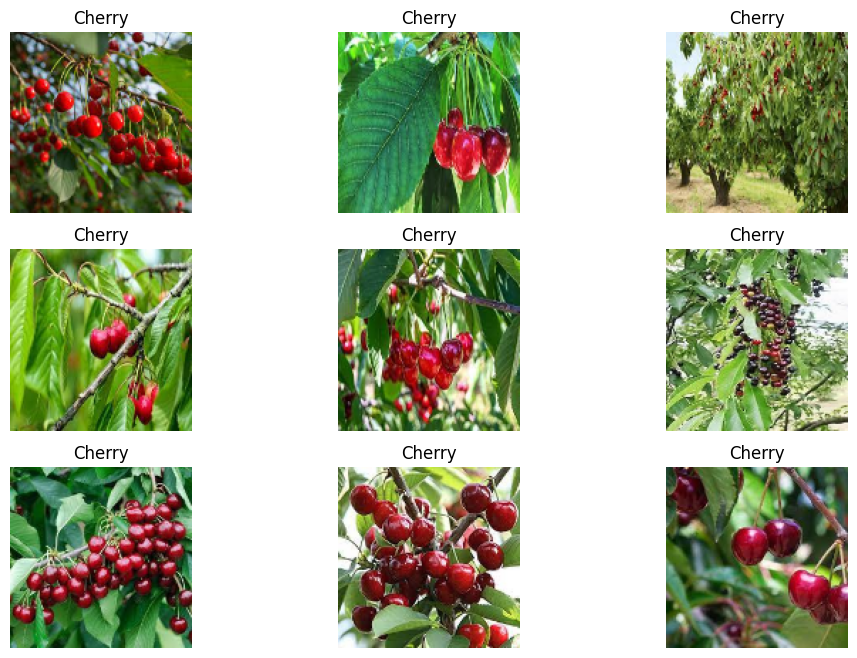

In [ ]:
# Chargement des images
images, labels, classes = load_images_from_drive(dataset_folder)
print(f"Dimensions des données : {images.shape}")

# Visualisation de quelques images
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()

<ipython-input-16-9c3949a1f61f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.values()), y=list(class_counts.keys()), palette="viridis")


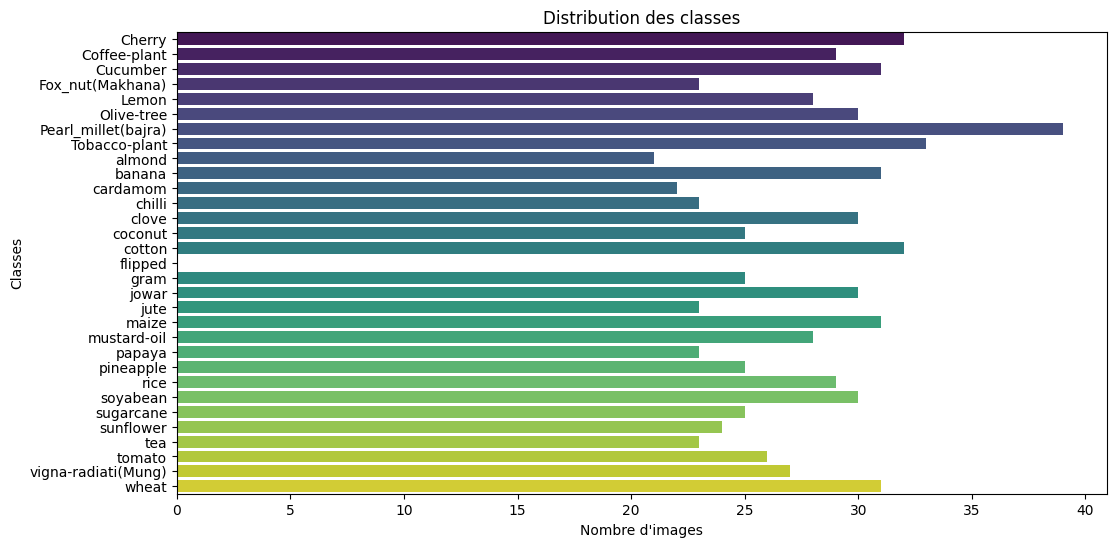

In [ ]:
# Analyse de la distribution des classes
class_counts = {cls: np.sum(labels == idx) for idx, cls in enumerate(classes)}
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.values()), y=list(class_counts.keys()), palette="viridis")
plt.title("Distribution des classes")
plt.xlabel("Nombre d'images")
plt.ylabel("Classes")
plt.show()


Augmentation de données

l'augmentation de données permet d'améliorer la robustesse et la précision de notre modèle. ce qui permet d optimiser les performances du modele

Utiliser l'augmentation des données peut entraîner plusieurs avantages :
1 Amélioration de la généralisation : En exposant le modèle à une plus grande variété de données, il apprend à mieux généraliser avec de nouvelles entrées.
2 Réduction du surapprentissage : Avec plus d'échantillons d'entraînement, le modèle est moins susceptible de surajuster au bruit dans les données d'entraînement.
3 Économique : Au lieu de collecter plus de données, vous pouvez créer de nouveaux échantillons à partir de votre ensemble de données existant, économisant ainsi du temps et des ressources.

In [ ]:
## A AMELIORER ET A ADAPTER


##   Retournement
## Retournement d'images horizontalement ou verticalement peut aider le modèle à apprendre des caractéristiques qui sont invariantes à l'orientation.
# Charger une image
image = cv2.imread('image.jpg')
# Retournement de l'image horizontalement
flipped_image = cv2.flip(image, 1)  # 1 pour horizontal, 0 pour vertical
cv2.imwrite('flipped_image.jpg', flipped_image)


## Rotation
## Faire pivoter des images peut aider le modèle à apprendre à reconnaître des objets sous différents angles.
# Charger une image
image = cv2.imread('image.jpg')
# Obtenir les dimensions de l'image
(h, w) = image.shape[:2]
# Définir la matrice de rotation
center = (w // 2, h // 2)
angle = 45  # Faire pivoter de 45 degrés
M = cv2.getRotationMatrix2D(center, angle, 1.0)
# Effectuer la rotation
rotated_image = cv2.warpAffine(image, M, (w, h))
cv2.imwrite('rotated_image.jpg', rotated_image)

##  Mise à l' échelle
## Mise à l'échelle des images peut aider le modèle à apprendre à reconnaître des objets de tailles différentes.
# Charger une image
image = cv2.imread('image.jpg')
# Mise à l'échelle de l'image
scaled_image = cv2.resize(image, None, fx=1.5, fy=1.5)  # Mise à l'échelle par 1,5 fois
cv2.imwrite('scaled_image.jpg', scaled_image)

## Translation
## Translater des images peut aider le modèle à apprendre à reconnaître des objets qui ne sont pas nécessairement centrés dans le cadre.
# Charger une image
image = cv2.imread('image.jpg')
# Définir la matrice de translation
M = np.float32([[1, 0, 50], [0, 1, 50]])  # Traduire de 50 pixels en x et y
translated_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
cv2.imwrite('translated_image.jpg', translated_image)

##  Ajout du bruit
## Ajouter du bruit aux images peut aider le modèle à devenir plus robuste aux variations des données d'entrée.
# Charger une image
image = cv2.imread('image.jpg')
# Ajouter du bruit gaussien
noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
noisy_image = cv2.add(image, noise)
cv2.imwrite('noisy_image.jpg', noisy_image)

##  Variation des couleurs
## Changer la luminosité, le contraste et la saturation des images peut aider le modèle à apprendre à reconnaître des objets sous différentes conditions d'éclairage.
# Charger une image
image = cv2.imread('image.jpg')
# Changer la luminosité
bright_image = cv2.convertScaleAbs(image, alpha=1, beta=50)  # Augmenter la luminosité
cv2.imwrite('bright_image.jpg', bright_image)
# Changer le contraste
contrast_image = cv2.convertScaleAbs(image, alpha=2, beta=0)  # Augmenter le contraste
cv2.imwrite('contrast_image.jpg', contrast_image)

In [ ]:
# Définition du modèle CNN : Convolutional Neural Network
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 31)                  │           3,999 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,308,639 (12.62 MB)

 Trainable params: 3,308,639 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Division des données
total_size = len(images)
train_size = int(0.8 * total_size)
X_train, X_test = images[:train_size], images[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]


In [ ]:
# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.0434 - loss: 3.4775 - val_accuracy: 0.0000e+00 - val_loss: 4.2953
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.0412 - loss: 3.2753 - val_accuracy: 0.0000e+00 - val_loss: 5.0405
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.0758 - loss: 3.1272 - val_accuracy: 0.0000e+00 - val_loss: 7.0357
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2124 - loss: 2.7812 - val_accuracy: 0.0000e+00 - val_loss: 9.9728
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2755 - loss: 2.5232 - val_accuracy: 0.0060 - val_loss: 12.8498
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3042 - loss: 2.3141 - val_accuracy: 0.0000e+00 - val_loss: 18.7634
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4251 - loss: 1.9232 - val_accuracy: 0.0000e+00 - val_loss: 21.1830
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5559 - loss: 1.4955 - val_a

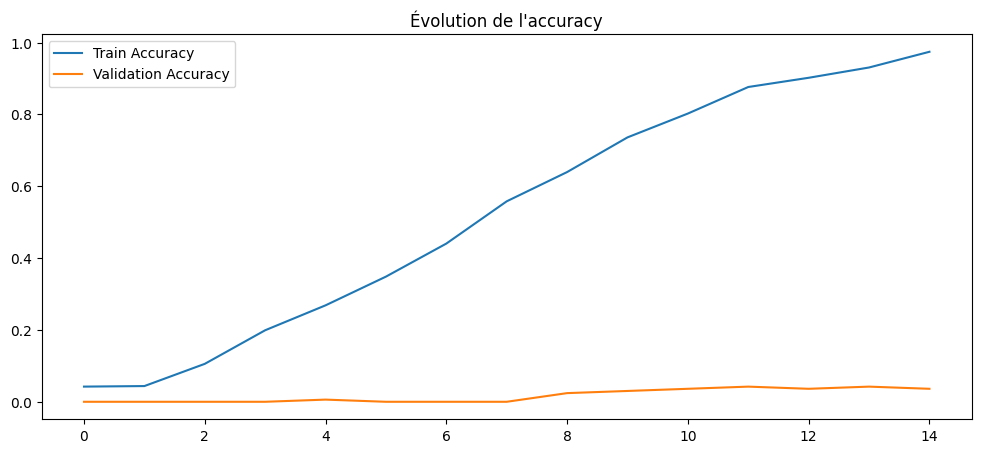

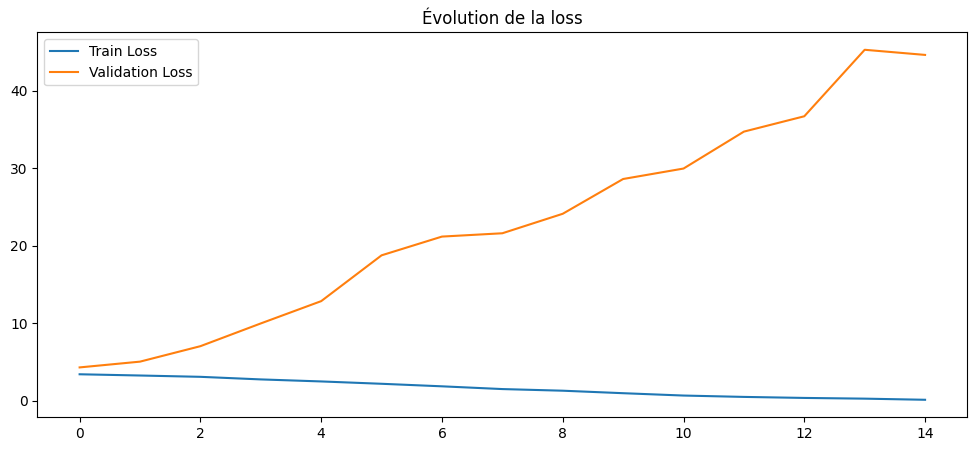

In [ ]:

# Affichage des courbes d'apprentissage
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Évolution de l'accuracy")
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Évolution de la loss")
plt.show()


# **Proposition de A. Camara par rapport à la suggestion de M. Kaba.**

In [ ]:
# Chemins d'entrée et de sortie
##input_folder = '/content/drive/MyDrive/Data/extracted_files/Agricultural-crops/'
input_folder = '/content/drive/MyDrive/Colab Notebooks/Agricultural-crops'
##output_folder = '/content/drive/MyDrive/Data/extracted_files/Agricultural-crops/flipped/'
output_folder = '/content/drive/MyDrive/Colab Notebooks/Agricultural-crops/flipped/'

# Créer le dossier de sortie s'il n'existe pas déjà
os.makedirs(output_folder, exist_ok=True)

# Lister tous les fichiers dans le dossier d'entrée
for filename in os.listdir(input_folder):
    # Vérifier si le fichier est une image (extensions courantes)
    if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        # Construire le chemin complet de l'image
        image_path = os.path.join(input_folder, filename)

        # Charger l'image
        image = cv2.imread(image_path)

        # Vérifier si l'image a été correctement chargée
        if image is not None:
            # Appliquer le retournement horizontal
            flipped_horizontal = cv2.flip(image, 1)
            output_path_horizontal = os.path.join(output_folder, f"flipped_horizontal_{filename}")
            cv2.imwrite(output_path_horizontal, flipped_horizontal)

            # Appliquer le retournement vertical
            flipped_vertical = cv2.flip(image, 0)
            output_path_vertical = os.path.join(output_folder, f"flipped_vertical_{filename}")
            cv2.imwrite(output_path_vertical, flipped_vertical)

            print(f"Images retournées sauvegardées : {output_path_horizontal} et {output_path_vertical}")
        else:
            print(f"Erreur : L'image {filename} n'a pas pu être chargée.")
